In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scripts.preprocess_files import proc_emg
import os
from scipy.signal import find_peaks, savgol_filter
import seaborn as sns
from scripts.preprocess_files import proc_imu

Codes here are a little messy. :( 

# Preprocessing, combining IMU and EMG data

* Iterates through the IMU and EMG excels, combines all data into one big dataframe for all participants 
* IMU and EMG filtering is also done during this step
* Pain levels are added

## Preprocess and combine 

In [2]:
def align_and_combine(imu_df, emg_df, imu_fps=60, emg_fps=2000, columns_to_keep=None):
    
    imu_df = imu_df.assign(time=imu_df.index / imu_fps)
    emg_df = emg_df.assign(time=emg_df.index / emg_fps)
    imu_df.set_index('time', inplace=True)
    emg_df.set_index('time', inplace=True)

    imu_resampled = imu_df.reindex(emg_df.index, method='nearest')
    if columns_to_keep:
        imu_resampled = imu_resampled[columns_to_keep]
    combined_df = pd.concat([imu_resampled, emg_df], axis=1)
    return imu_resampled, emg_df, combined_df

def assign_group_numbers(df):
    df = df.loc[:, ~df.columns.duplicated()] 
    marker_change = (df['Marker'] != df['Marker'].shift()).astype(int)
    frame_gap = ((df['Frame'] != df['Frame'].shift()) & (df['Frame'] != df['Frame'].shift() + 1)).astype(int)
    group_change = marker_change | frame_gap  # This creates a new group if either condition is True
    df['group_num'] = group_change.cumsum()
    return df

def get_sessions(person_path):
    session_folders = [folder for folder in os.listdir(person_path) if folder.startswith("session")]
    return sorted(session_folders)

def fix_typo_columns(df):
    df['Marker'] = df['Marker'].str.strip()
    df['Marker'] = df['Marker'].replace('hip lside', 'hip slide')
    df['Marker'] = df['Marker'].replace('bakc', 'back')
    df['Marker'] = df['Marker'].replace('mobilizatin', 'mobilization')
    df['Marker'] = df['Marker'].replace('slid', 'slide')
    df['Marker'] = df['Marker'].replace('side back extension EP sset', 'side back extension EP set')
    df['Marker'] = df['Marker'].replace('hip lside', 'hip lside')
    df['Marker'] = df['Marker'].replace('slid', 'slide')
    df['Marker'] = df['Marker'].replace('band over', 'bend over')
    df['Marker'] = df['Marker'].replace('bend ovr', 'bend over')
    df['Marker'] = df['Marker'].replace('hip lside', 'hip slide')
    df['Marker'] = df['Marker'].replace('back extension hol', 'back extension hold')
    return df

def preprocess_session_data(name, session_folder, imu_fps=60, emg_fps=2000, drop_nan_exercise=False):
    session_id = os.path.basename(session_folder)
    imu_path = os.path.join(session_folder, f"{session_id}.pkl")
    emg_path = os.path.join(session_folder, f"{session_id}_emg.pkl")
    imu = pd.read_pickle(imu_path)
    emg = pd.read_pickle(emg_path)
    
    # Handle NaN values in the 'Marker' column: either drop them or label as other
    if drop_nan_exercise:
        imu = imu.dropna(subset=['Marker'])
        emg = emg.dropna(subset=['Marker'])
    else:
        imu['Marker'] = imu['Marker'].fillna('other')
        emg['Marker'] = emg['Marker'].fillna('other')
    
    # Convert numeric columns to float32
    imu_numeric_cols = imu.select_dtypes(include=['number']).columns.drop('Frame', errors='ignore')
    emg_numeric_cols = emg.select_dtypes(include=['number']).columns.drop(['Frame','Sample'], errors='ignore')

    imu[imu_numeric_cols] = imu[imu_numeric_cols].astype('float32')
    emg[emg_numeric_cols] = emg[emg_numeric_cols].astype('float32')

    # Preprocess EMG: extract emg envelope
    emg = proc_emg(emg, name)
    
    # Preprocess IMU: low-pass filter
    imu = proc_imu(imu)
    
    # Combine them into one df 
    _, _, combined_df = align_and_combine(imu, emg, imu_fps=imu_fps, emg_fps=emg_fps)

    session_id = session_folder.split('session')[-1]  # Extract session number
    combined_df['session_id'] = session_id
    combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]
    combined_df = fix_typo_columns(combined_df)
    
    combined_df = combined_df.iloc[::2] # Resample to 1000 hz  
    return combined_df

# Function to combine all sessions for a given person into one DataFrame
def combine_all_sessions(person_name, person_path):
    session_folders = get_sessions(person_path)
    all_sessions_df = []
    
    for session_folder in session_folders:
        print(f"Processing {person_name}, {session_folder}...")
        session_folder_path = os.path.join(person_path, session_folder)
        combined_session_df = preprocess_session_data(person_name, session_folder_path)
        all_sessions_df.append(combined_session_df)
    
    all_sessions_df = [df.loc[:, ~df.columns.duplicated()] for df in all_sessions_df]
    final_combined_df = pd.concat(all_sessions_df, axis=0, ignore_index=True)
    final_combined_df = assign_group_numbers(final_combined_df)

    return final_combined_df

In [3]:
participants = ["Anita", "Dávid", "Flóra", "István", "Kitti", "Kristóf", "Margita", "Patrik", "Petra", "Zoltán"]
all_participants_data = [] 

for person_name in participants:    
    person_path = f"../data/raw/{person_name}/"
    final_combined_df = combine_all_sessions(person_name, person_path)

    final_combined_df['Participant'] = person_name
    print(final_combined_df.shape)
    
    pickle_path = os.path.join(f"../data/processed/{person_name}/", f"all.pkl")
    final_combined_df.to_pickle(pickle_path)
    print(f"df saved to {pickle_path}")
    
    all_participants_data.append(final_combined_df)

# Combine all participants' df into one
combined_all_participants_df = pd.concat(all_participants_data, axis=0, ignore_index=True)

# Save it
print("saving the combined dataframe...")
combined_pickle_path = "../data/processed/combined_all.pkl"
combined_all_participants_df.to_pickle(combined_pickle_path)
print(f"Combined DataFrame saved to {combined_pickle_path}")

Processing Anita, session1...
Processing column: left
Processing column: right
Processing Anita, session2...
Processing column: left
Processing column: right
Processing Anita, session3...
Processing column: left
Processing column: right
Processing Anita, session4...
Processing column: left
Processing column: right
(2370352, 143)
df saved to ../data/processed/Anita/all.pkl
Processing Dávid, session1...
Processing column: left
Processing column: right
Processing Dávid, session2...
Processing column: left
Processing column: right
Processing Dávid, session3...
Processing column: left
Processing column: right
Processing Dávid, session4...
Processing column: left
Processing column: right
(4434714, 143)
df saved to ../data/processed/Dávid/all.pkl
Processing Flóra, session1...
Processing column: left
Processing column: right
Processing Flóra, session2...
Processing column: left
Processing column: right
Processing Flóra, session3...
Processing column: left
Processing column: right
Processing Fl

## Add pain levels 

Reduce dataframe first to only have the most popular exercises

In [2]:
combined_all_participants_df = pd.read_pickle("../data/processed/combined_all.pkl")
combined_all_participants_df.shape

(34718139, 145)

In [ ]:
needed_markers = ["back extension set", "bend over", "bend back", "hip slide", "rotate"]
filt = combined_all_participants_df[combined_all_participants_df["Marker"].isin(needed_markers)]
print("Filtered DataFrame shape:", filt.shape)

Add the pain levels

In [8]:
rm_oi_df = pd.read_pickle("data/rm_oi_df.pkl") 
rm_oi_df['session_id'] = rm_oi_df['session_id'].astype(int)
filt['session_id'] = filt['session_id'].astype(int)
combined_all_participants_df = pd.merge(filt, rm_oi_df, on=['Participant', 'session_id'], how='left')

C:\Users\Hp\AppData\Local\Temp\ipykernel_19796\278600894.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt['session_id'] = filt['session_id'].astype(int)


In [9]:
combined_all_participants_df.shape 

(11317827, 147)

Now this dataframe contains all the data we will use. Let's save it

In [10]:
combined_all_participants_df.to_pickle("all.pkl")

# Check data

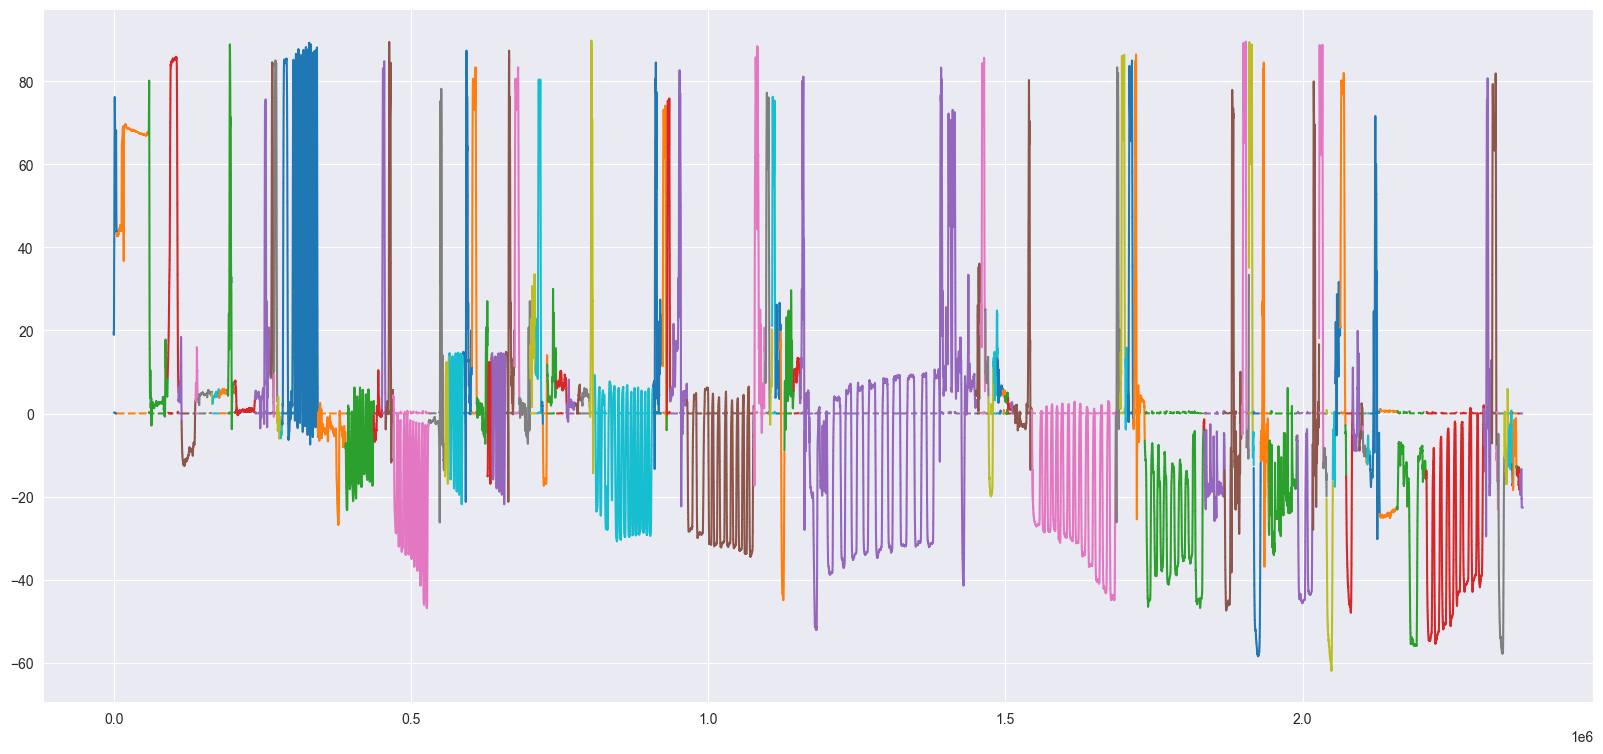

In [8]:
"""label_joint_angle = "Left Hip Flexion/Extension joint_angle"
label_emg = "left envelope"

filtered_df = combined_all_participants_df[combined_all_participants_df["Participant"] == "Anita"]
plt.figure(figsize=(20, 9))

# Define a colormap to assign different colors to each group_num
colormap = pyplot.get_cmap('tab10')
unique_groups = filtered_df['group_num'].unique()

# Plot each group_num with a different color
for i, group_num in enumerate(unique_groups):
    group_df = filtered_df[filtered_df['group_num'] == group_num]
    color = colormap(i % colormap.N)  # Cycle through the colors

    # Plot Left Hip joint angle
    plt.plot(group_df.index, group_df[label_joint_angle], label=f'Group {group_num} - Joint Angle', color=color)

    # Plot Left EMG envelope with the same color, but dashed line
    plt.plot(group_df.index, group_df[label_emg], label=f'Group {group_num} - EMG', linestyle='--', color=color)

# Add legend and show plot
#plt.legend()
plt.show()"""

# Further processing

## Drift correction

Joint angles show a little drift - the repetitions shift significantly during a set. This is removed using linear corection if the drift is bigger than 5 degrees between the beginning of the set, and the end of the set. (Applied for each joint angle set) 

In [30]:
def correct_drift(df, joint_angle_col):
    start_neutral = df[joint_angle_col].iloc[0]  # Neutral position at the start
    end_neutral = df[joint_angle_col].iloc[-1]   # Neutral position at the end
    drift = end_neutral - start_neutral
    
    if abs(drift) > 5:  
        relative_position = (df.index - df.index.min()) / (df.index.max() - df.index.min())
        drift_correction = relative_position * drift  # Apply linear correction
        df[joint_angle_col] -= drift_correction
    
    return df

def apply_drift_correction(df, joint_angle_cols, exercise):
    available_groups = df[df['Marker'] == exercise]['group_num'].unique()

    if len(available_groups) == 0:
        print(f"No available groups for {exercise}.")
        return df

    # Apply drift correction for each group and each joint angle column
    for group_num in available_groups:
        group_indices = df[df['group_num'] == group_num].index

        for joint_angle_col in joint_angle_cols:
            corrected_group = correct_drift(df.loc[group_indices], joint_angle_col)
            dtype = df[joint_angle_col].dtype
            df.loc[group_indices, joint_angle_col] = corrected_group[joint_angle_col].astype(dtype)  # Cast to original dtype

    return df

def correct_drift_for_all(df, joint_angle_cols, exercise='back extension set'):
    participants = df['Participant'].unique()  # Get all unique participants

    for participant in participants:
        print(f"Applying drift correction for participant: {participant}")
        participant_indices = df[df['Participant'] == participant].index  
        df.loc[participant_indices] = apply_drift_correction(df.loc[participant_indices], joint_angle_cols, exercise)

    return df

joint_angle_cols = [col for col in combined_all_participants_df.columns if 'joint_angle' in col]
exercise = "back extension set"
corrected_all_df = correct_drift_for_all(combined_all_participants_df, joint_angle_cols, exercise)
corrected_all_df.to_pickle("drift_corrected.pkl")

Applying drift correction for participant: Anita
Applying drift correction for participant: Dávid
Applying drift correction for participant: Flóra
Applying drift correction for participant: István
Applying drift correction for participant: Kitti
Applying drift correction for participant: Kristóf
Applying drift correction for participant: Margita
Applying drift correction for participant: Patrik
Applying drift correction for participant: Petra
Applying drift correction for participant: Zoltán


## Label repetitions

#### Smooth signal, detect peaks, label reps based on that

In [2]:
corrected_all_df = pd.read_pickle("drift_corrected.pkl")

In [3]:
def smooth_savgol(series, window_size, poly_order=3):
    if window_size > len(series):     # Ensure window size does not exceed series length
        return series
    smoothed_values = savgol_filter(series, window_length=window_size, polyorder=poly_order)
    smoothed_series = pd.Series(smoothed_values, index=series.index)  # Preserve original index
    return smoothed_series

def process_groups(df, joint_angle_col, window_size=2001):
    df["cleaned_minima"] = False
    df["cleaned_maxima"] = False

    for group_num in df["group_num"].unique():
        group_df = df[df["group_num"] == group_num]
        signal = group_df[joint_angle_col] 
        sg_signal = smooth_savgol(signal, window_size=window_size)
        
        hip_angle_minima, _ = find_peaks(-sg_signal, distance=2500, prominence=5)
        hip_angle_maxima, _ = find_peaks(sg_signal, distance=2500, prominence=5)

        df.loc[signal.iloc[hip_angle_minima].index, "cleaned_minima"] = True
        df.loc[signal.iloc[hip_angle_maxima].index, "cleaned_maxima"] = True

    return df

def label_repetitions_max_to_max_or_min_to_min(processed_df):
    peak_indices = processed_df[processed_df["cleaned_maxima"]].index 
    processed_df["Reps"] = np.nan
    for i in range(1, len(peak_indices)):
        start_idx = peak_indices[i - 1]
        end_idx = peak_indices[i]
        processed_df.loc[start_idx:end_idx, "Reps"] = i
    return processed_df


def process_movement_type(df, movement):
    # Define the appropriate joint angle column for each movement. Labelling reps will be based on this. 
    window_size = 2001
    joint_angle_col = "Left Hip Flexion/Extension joint_angle"
    
    if movement=="rotate":
        joint_angle_col = "L1T12 Axial Rotation joint_angle"
    elif movement == "hip slide":
        joint_angle_col = "Vertical_T8 Lateral Bending ergo_joint_angle"
    elif movement == "back extension set":
        joint_angle_col = "Left Hip Flexion/Extension joint_angle"
        window_size = 5001
    
    # Smoothing and peak marking
    df = process_groups(df, joint_angle_col, window_size)

    if movement != "back extension set":
        df[joint_angle_col] = df.groupby("group_num")[joint_angle_col].transform(lambda x: x - x.min())
        
        if movement == "bend back":
            df = df[~((df["Participant"] == "Zoltán") & (df["group_num"].isin([51, 91])))]
            df = df[~((df["Participant"] == "István") & (df["group_num"].isin([31, 84, 114])))]
        elif movement == "bend over":
            df = df[~((df["Participant"] == "Margita") & (df["group_num"] == 62))]
        
        # Label the entire segment as a single repetition
        df["Reps"] = df["group_num"]
    else:
        # Use the max-to-max or min-to-min labeling for other movements
        df = label_repetitions_max_to_max_or_min_to_min(df)

    return df

def process_all_participants_for_movements(df):
    movements = ["back extension set", "bend over", "bend back", "rotate", "hip slide"]
    participants = df['Participant'].unique()
    combined_processed_df = pd.DataFrame()

    for movement in movements:
        print(f"Processing movement type: {movement}")
        movement_df = df[df["Marker"] == movement]
        
        for participant in participants:
            print(f"  Processing data for participant: {participant}")
            participant_df = movement_df[movement_df['Participant'] == participant].copy()
            processed_df = process_movement_type(participant_df, movement)
            combined_processed_df = pd.concat([combined_processed_df, processed_df], axis=0)
    
    return combined_processed_df

asd = process_all_participants_for_movements(corrected_all_df )

Processing movement type: back extension set
  Processing data for participant: Anita
  Processing data for participant: Dávid
  Processing data for participant: Flóra
  Processing data for participant: István
  Processing data for participant: Kitti
  Processing data for participant: Kristóf
  Processing data for participant: Margita
  Processing data for participant: Patrik
  Processing data for participant: Petra
  Processing data for participant: Zoltán
Processing movement type: bend over
  Processing data for participant: Anita
  Processing data for participant: Dávid
  Processing data for participant: Flóra
  Processing data for participant: István
  Processing data for participant: Kitti
  Processing data for participant: Kristóf
  Processing data for participant: Margita


C:\Users\Hp\AppData\Local\Temp\ipykernel_13172\648044903.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Reps"] = df["group_num"]


  Processing data for participant: Patrik
  Processing data for participant: Petra
  Processing data for participant: Zoltán
Processing movement type: bend back
  Processing data for participant: Anita
  Processing data for participant: Dávid
  Processing data for participant: Flóra
  Processing data for participant: István
  Processing data for participant: Kitti
  Processing data for participant: Kristóf
  Processing data for participant: Margita
  Processing data for participant: Patrik
  Processing data for participant: Petra
  Processing data for participant: Zoltán
Processing movement type: rotate
  Processing data for participant: Anita
  Processing data for participant: Dávid
  Processing data for participant: Flóra
  Processing data for participant: István
  Processing data for participant: Kitti
  Processing data for participant: Kristóf
  Processing data for participant: Margita
  Processing data for participant: Patrik
  Processing data for participant: Petra
  Processing d

#### Remove really long reps (outliers) - those were labelled incorrectly

In [ ]:
def calculate_rep_times(processed_df, sampling_rate=1000):
    unique_reps = processed_df["Reps"].dropna().unique()
    rep_times = {}
    for rep_num in unique_reps:
        rep_df = processed_df[processed_df["Reps"] == rep_num]
        rep_duration = (rep_df.index.max() - rep_df.index.min()) / sampling_rate  # Convert to seconds
        rep_times[rep_num] = rep_duration
    return rep_times

def remove_outliers_iqr(rep_times, iqr_multiplier=1.5):
    times = list(rep_times.values())
    Q1 = np.percentile(times, 25)
    Q3 = np.percentile(times, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - iqr_multiplier * IQR
    upper_bound = Q3 + iqr_multiplier * IQR
    
    outliers = {rep: time for rep, time in rep_times.items() if time < lower_bound or time > upper_bound}
    if outliers:
        print("Outliers removed (Reps):", outliers)
    
    filtered_rep_times = {rep: time for rep, time in rep_times.items() if lower_bound <= time <= upper_bound}
    return filtered_rep_times

def calculate_and_plot_rep_times_without_outliers_iqr_by_participant(processed_df, sampling_rate=1000):
    unique_markers = processed_df["Marker"].unique()
    combined_filtered_df = pd.DataFrame()

    for marker in unique_markers:
        print(f"\nProcessing repetition times for exercise: '{marker}'")
        exercise_df = processed_df[processed_df["Marker"] == marker]
        
        for participant in exercise_df["Participant"].unique():
            print(f"  Processing participant: '{participant}'")
            participant_df = exercise_df[exercise_df["Participant"] == participant]
            
            # Calculate the repetition times for the participant
            rep_times = calculate_rep_times(participant_df, sampling_rate)
            
            # Plot the distribution before outlier removal
            plt.figure(figsize=(12, 6))
            sns.histplot(list(rep_times.values()), kde=True, color='skyblue')
            plt.title(f'Distribution of Repetition Times for {marker} - {participant} (Before Outlier Removal)')
            plt.xlabel('Time (Seconds)')
            plt.ylabel('Frequency')
            plt.show()
            
            # Remove outliers
            filtered_rep_times = remove_outliers_iqr(rep_times)
            
            plt.figure(figsize=(12, 6))
            sns.histplot(list(filtered_rep_times.values()), kde=True, color='skyblue')
            plt.title(f'Distribution of Repetition Times for {marker} - {participant} (After Outlier Removal)')
            plt.xlabel('Time (Seconds)')
            plt.ylabel('Frequency')
            plt.show()
            reps = np.arange(1, len(filtered_rep_times) + 1)
            plt.figure(figsize=(10, 6))
            plt.bar(reps, list(filtered_rep_times.values()), color='skyblue')
            plt.xlabel('Repetition')
            plt.ylabel('Time (Seconds)')
            plt.title(f'Time per Repetition for {marker} - {participant} (Outliers Removed)')
            plt.show()
            
            filtered_df = participant_df[participant_df["Reps"].isin(filtered_rep_times.keys())]
            combined_filtered_df = pd.concat([combined_filtered_df, filtered_df], axis=0)
    
    return combined_filtered_df


new_df = calculate_and_plot_rep_times_without_outliers_iqr_by_participant(asd, sampling_rate=1000)
new_df.to_pickle("reps_removed.pkl")

## Remove faulty emg cols

Where EMG data was missing or was too big (contact issue)

In [7]:
df = pd.read_pickle("data/reps_removed.pkl")

In [9]:
min_threshold = 0.01  
max_threshold = 1.3

# Filter out rows with unrealistic envelope values
filtered_df = df[
    (df['left envelope'] > min_threshold) & 
    (df['left envelope'] < max_threshold) & 
    (df['right envelope'] > min_threshold) & 
    (df['right envelope'] < max_threshold)
]

rows_removed = df.shape[0] - filtered_df.shape[0]
print(f"Number of rows removed: {rows_removed}")

Number of rows removed: 1417911


In [10]:
filtered_df.to_pickle("data/df_for_feature_extraction_with_emg.pkl")
print("saved!")

saved!
